# Pharmaceutical Manufacturing Outsourcing Optimization
## Background
This project seeks to approach a common pharmaceutical industry challenge of scaling a drug to production after FDA approval. 
There is urgency in the process of scaling to production because after filing, the patent for the drug is only held by the company for 10 years 
and vertically integrating is no longer the most economically viable option. 3rd party vendors must be employed to sequentially 
build the molecule over many steps that results in the active pharmaceutical ingredient (API). Selection of these vendors can be 
a strenous and inefficient process to work out as dozens of steps is common to build an API, however if each vendor is modeled by a
set of parameters, computational optimization is the perfect tool to rapidly determine the third party vendor sequence for API 
construction that allows for the pharma company to realize the maximum profit the patent is able to produce within the 10 year period.



# Problem Description

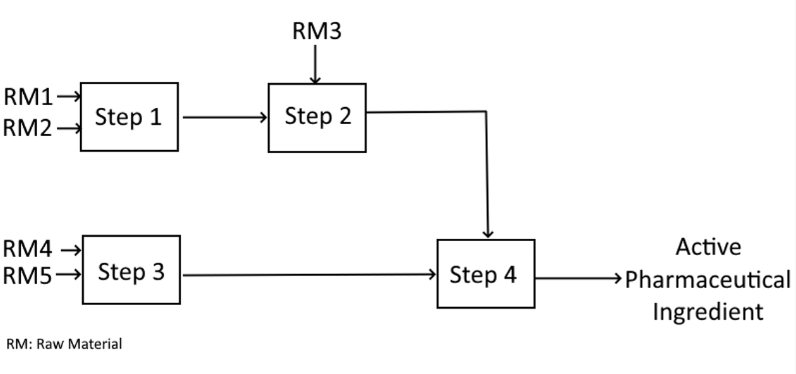

Consider the above flowsheet, in which raw materials are input to a sequence of steps, each step representing a unit operation type such as a reaction or separation. The final product of all of these steps is an Active Pharmaceutical Ingredient (API). For a given step it is possible to go from reagents to products represented by different sequences that encompass types of operations such as batch, hybrid, or continuous reactors.

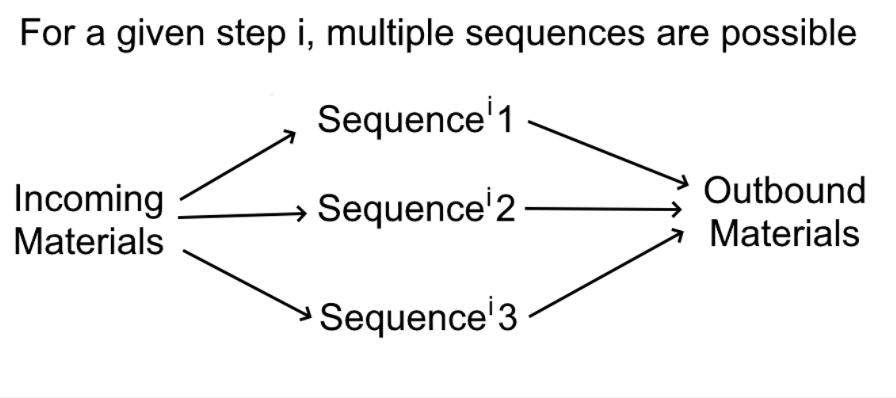

A pharmaceutical company that has just patented an API and wishes to produce it via this synthesis pathway must outsource the steps to third party vendors to retain a competitive advantage. Third party vendors are individually capable of some steps via some synthesis pathways as displayed below. 

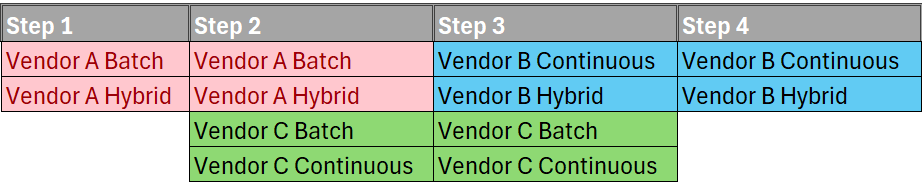

The challenge is determining the best vendors to assign to each step. Computational optimization provides a modern tool to efficiently determine the best vendor for each step by minmizing the cost necessary to produce the products from the reactants. For this problem considering all possibilities in a superstructure results in the following flow sheet.

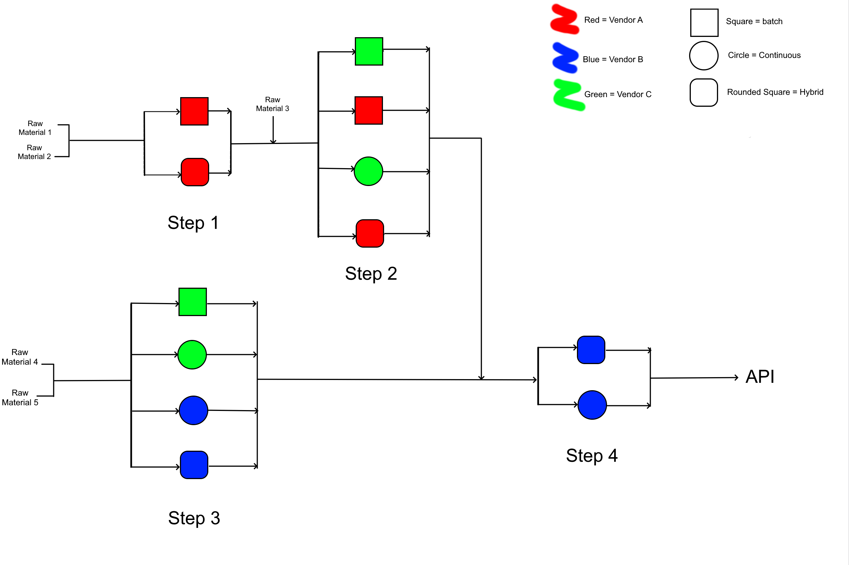

In [1]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def flow_from_csv(file_path = "FlowData.csv"):
    df = pd.read_csv(file_path, index_col=0)

    data = {}

    for (_, (u, v, flow, process_cost, transportation_cost)) in df.iterrows():
        data[(u, v)] = {"flow": flow ,"process_cost": process_cost, "transportation_cost": transportation_cost}

    return data

# Function to define node positions
NODE_POSITIONS = {
    "n0": (-3, 3), "n1": (-3, 2), "n2": (-2, 2.5), "n3": (-1, 2.5),
    "n4": (0, 3.3), "n5": (0, 1.8), "n6": (1, 2.5), "n7": (2, 2.5),
    "n8": (2, 3.3), "n9": (3, 2.5), "n10": (4, 3.3), "n11": (4, 2.8),
    "n12": (4, 2.3), "n13": (4, 1.8), "n14": (5, 2.5), "n15": (6, 2.5),
    "n16": (-3, 0.5), "n17": (-3, -0.5), "n18": (-2, 0), "n19": (-1, 0),
    "n20": (0, 0.8), "n21": (0, 0.3), "n22": (0, -0.2), "n23": (0, -0.8),
    "n24": (1, 0), "n25": (6, 0), "n26": (7, 0), "n27": (8, 0.8),
    "n28": (8, -0.8), "n29": (9, 0), "n30": (10, 0)
}

def get_step_titles():
    return {
        "Step A": (0, 1.4), "Step B": (4, 1.4), "Step C": (0, -1.3), "Step D": (8, -1.3)
    }

# Function to define edges with costs and penalties
EDGES_WITH_WEIGHTS = flow_from_csv()

NODE_COLORS = {
    "V_A": "lightcoral", "V_B": "lightblue", "V_C": "lightgreen"
}

NODE_LABELS = {
    "n4": "V_A", "n5": "V_A", "n13": "V_A", "n11": "V_A",
    "n10": "V_B", "n12": "V_B", "n20": "V_B", "n21": "V_B",
    "n22": "V_C", "n23": "V_C", "n28": "V_C", "n27": "V_C"
}

In [3]:


class FlowsheetOptimization:
    def __init__(self, edges_with_weights = EDGES_WITH_WEIGHTS, node_positions = NODE_POSITIONS):
        """
        Initializes the optimization flowchart with the given edges and node positions.
        Parameters:
        edges_with_weights (dict): A dictionary where keys are tuples representing edges (u, v) and values are dictionaries containing edge attributes such as 'flow', 'process_cost', and 'transportation_cost'.
        node_positions (dict): A dictionary where keys are node identifiers and values are their positions.
        Attributes:
        edges_with_weights (dict): Stores the edges with their respective weights.
        node_positions (dict): Stores the positions of the nodes.
        graph (networkx.DiGraph): Directed graph representing the flowsheet.
        source_nodes (list): List of source nodes (nodes with no incoming edges).
        inner_nodes (list): List of inner nodes (nodes with both incoming and outgoing edges).
        sink_nodes (list): List of sink nodes (nodes with no outgoing edges).
        flow_network (dict): Dictionary mapping edges to their flow values.
        flow_cost (dict): Dictionary mapping edges to their process_cost values.
        disj_penalty (dict): Dictionary mapping edges to their transportation_cost values.
        model (pyomo.environ.ConcreteModel): Pyomo model built for optimization.
        """
        # Initialize the optimization flowchart with the given edges and node positions
        self.edges_with_weights = edges_with_weights
        self.node_positions = node_positions
        self.graph = nx.DiGraph()

        for node in self.node_positions.keys():
            self.graph.add_node(node, position = self.node_positions[node])

        for ((u, v), data) in self.edges_with_weights.items():
            self.graph.add_edge(u, v, **data)

        self.source_nodes = []
        self.inner_nodes = []
        self.sink_nodes = []

        for node in self.graph.nodes():
            if self.graph.in_degree(node) == 0:
                self.source_nodes.append(node)
            elif self.graph.out_degree(node) == 0:
                self.sink_nodes.append(node)
            else:
                self.inner_nodes.append(node)

        # self.flow_network = {edge: edge for edge in self.graph.edges()}
        self.flow_network = {(u, v): data["flow"] for (u, v, data) in self.graph.edges(data=True)}
        self.flow_cost = {(u, v): data["process_cost"] for (u, v, data) in self.graph.edges(data=True)}
        self.disj_penalty = {(u, v): data["transportation_cost"] for (u, v, data) in self.graph.edges(data=True)}
        
        self.model = self.build_pyomo_model()

    def inflow(self, model, node):
        return sum(model.f[edge] for edge in self.graph.in_edges(node))
    
    def outflow(self, model, node):
        return sum(model.f[edge] for edge in self.graph.out_edges(node))

    def build_pyomo_model(self):
        """
        Build a Pyomo optimization model for flowsheet optimization.

        This method constructs a Pyomo ConcreteModel to optimize the flow through a network.
        The model includes binary decision variables for each flow, process costs, and transportation costs.
        It also enforces flow conservation constraints at inner nodes, sink nodes, and source nodes.
        The objective is to minimize the total cost, which includes process costs and transportation costs.

        Returns:
            ConcreteModel: A Pyomo ConcreteModel representing the flowsheet optimization problem.
        """
        # Create a Pyomo ConcreteModel
        model = pyo.ConcreteModel(doc="flowsheet Optimization Model")

        # Define sets, parameters, and variables
        model.flows = pyo.Set(initialize=self.flow_network.keys(), doc="flows")
        model.f = pyo.Var(model.flows, domain=pyo.Binary, doc="flow binary decision on each edge")   
        model.fcost = pyo.Param(model.flows, initialize=self.flow_cost, mutable=True, doc="process cost")
        model.K = pyo.Param(model.flows, initialize=self.disj_penalty, mutable=True, doc="transportation cost")

        # Define total flow as a parameter
        total_flow = 1  # Define total_flow as 1 or any other appropriate value

        # Add constraints to ensure flow conservation at each node
        model.inner_flow_conservation = pyo.Constraint(
            self.inner_nodes,
            rule=lambda model, node: self.inflow(model, node) == self.outflow(model, node),
            doc="inner flow conservation"
        )

        # Sink nodes should inflow the same amount of flow as the total flow
        model.sink_flow_conservation = pyo.Constraint(
            rule=lambda model: (sum(self.inflow(model, node) for node in self.sink_nodes) == total_flow),
            doc="sink flow conservation"
        )

        # Source nodes should outflow the same amount of flow as the total flow
        model.source_flow_conservation = pyo.Constraint(
            rule=lambda model: (sum(self.outflow(model, node) for node in self.source_nodes) == total_flow),
            doc="source flow conservation"
        )


        # Objective function to minimize total cost

        model.totalcost = pyo.Objective(
            expr = sum(model.f[edge] * model.fcost[edge] for edge in self.graph.edges()) * total_flow
                 + sum(model.f[edge] * model.K[edge] for edge in self.graph.edges()),
            sense=pyo.minimize,
            doc="total cost",
        )

        return model

    def solve_model(self):
        solver = pyo.SolverFactory("gurobi")
        solver.solve(self.model, tee=True)
        return {edge: pyo.value(self.model.f[edge]) for edge in self.graph.edges()}
    

In [4]:

def visualize_optimized_network(edges_with_weights, optimized_flows):

    """
    Visualizes the optimized network using NetworkX and Matplotlib.
    Parameters:
        edges_with_weights (dict): A dictionary where keys are tuples representing edges (u, v) and values are dictionaries containing edge attributes such as 'flow', 'process_cost', and 'transportation_cost'.
        optimized_flows (dict): A dictionary where keys are tuples representing edges (u, v) and values are the optimized flow values.
    Returns:
        None
    """

    G = nx.DiGraph()
    G.add_edges_from(edges_with_weights.keys())
    pos = NODE_POSITIONS
    plt.figure(figsize=(30, 14))

    # Assign node colors and labels
    node_color_list = [NODE_COLORS.get(NODE_LABELS.get(node, ""), "lightgray") for node in G.nodes()]
    labels = {node: NODE_LABELS.get(node, node) for node in G.nodes()}
    
    # Draw nodes
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=1500, node_color=node_color_list, edgecolors='black', font_size=14)
    
    # Draw edges
    active_edges = [edge for edge, decision in optimized_flows.items() if decision == 1]
    inactive_edges = [edge for edge, decision in optimized_flows.items() if decision == 0]
    nx.draw_networkx_edges(G, pos, edgelist=inactive_edges, arrowstyle="-", edge_color='black', width=3)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, arrowstyle="-", edge_color='blue', width=3)


    # Draw edge labels 
    edge_labels = {
        edge: f"F{i+1}: {optimized_flows[edge]}\nprocess_cost: {data['process_cost']}\ntransportation_cost: {data['transportation_cost']}"
        for i, (edge, data) in enumerate(edges_with_weights.items())
    }
    
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color='black', font_size=6, label_pos=0.5,
        bbox=dict(facecolor='white', edgecolor='none', alpha=1)
    )
    
    # Draw step titles
    step_titles = get_step_titles()
    for title, position in step_titles.items():
        plt.text(position[0], position[1], title, fontsize=24, fontweight="bold", color="orange", ha="center", va="center")
    

    plt.title("Optimized Flowsheet", fontsize=36, fontweight="bold", loc="left")
    plt.show()


flowsheet Optimization Model

    1 Set Declarations
        flows : flows
            Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     2 :    Any :   38 : {('n0', 'n2'), ('n1', 'n2'), ('n2', 'n3'), ('n3', 'n4'), ('n3', 'n5'), ('n4', 'n6'), ('n5', 'n6'), ('n6', 'n7'), ('n7', 'n9'), ('n8', 'n7'), ('n9', 'n10'), ('n9', 'n11'), ('n9', 'n12'), ('n9', 'n13'), ('n10', 'n14'), ('n11', 'n14'), ('n12', 'n14'), ('n13', 'n14'), ('n14', 'n15'), ('n15', 'n25'), ('n16', 'n18'), ('n17', 'n18'), ('n18', 'n19'), ('n19', 'n20'), ('n19', 'n21'), ('n19', 'n22'), ('n19', 'n23'), ('n20', 'n24'), ('n21', 'n24'), ('n22', 'n24'), ('n23', 'n24'), ('n24', 'n25'), ('n25', 'n26'), ('n26', 'n27'), ('n26', 'n28'), ('n27', 'n29'), ('n28', 'n29'), ('n29', 'n30')}

    2 Param Declarations
        K : transportation cost
            Size=38, Index=flows, Domain=Any, Default=None, Mutable=True
            Key            : Value
              ('n0', 'n2') :  

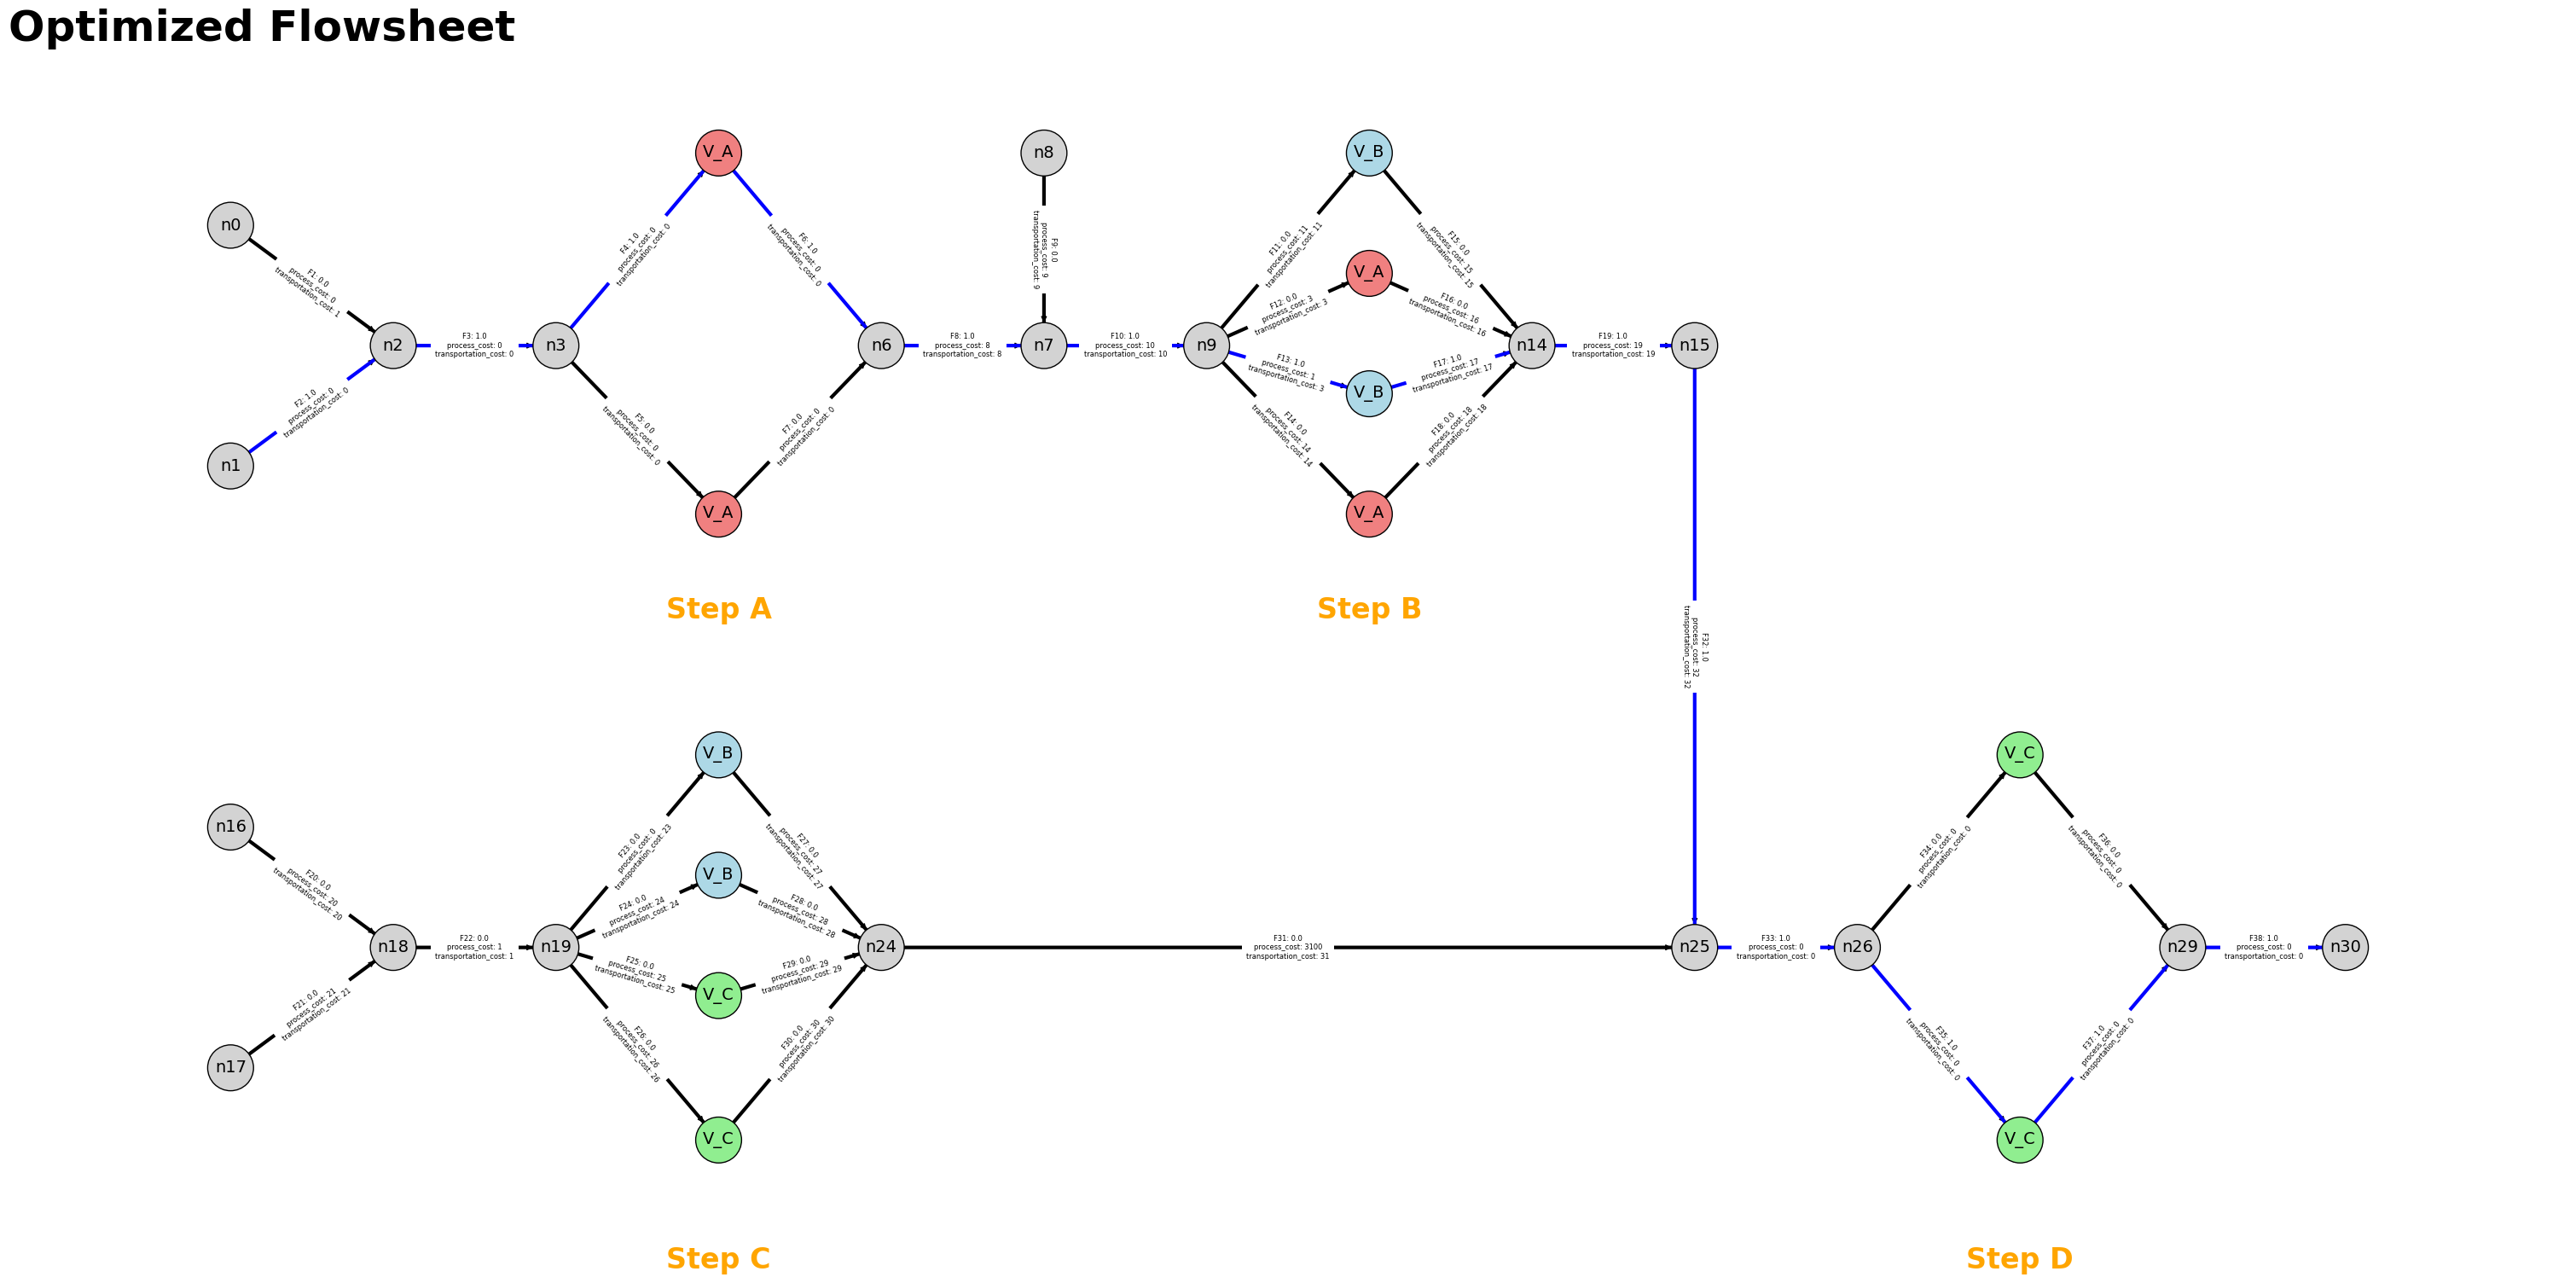

In [5]:

def main():
    """
    Main function to execute the flowsheet optimization process.

    This function performs the following steps:
    1. Initializes the FlowsheetOptimization object.
    2. Prints the model details.
    3. Solves the optimization model to get the optimized flows.
    4. Visualizes the optimized network using the edges with weights and the optimized flows.

    Returns:
        None
    """

    optimizer = FlowsheetOptimization()
    optimizer.model.pprint()
    optimized_flows = optimizer.solve_model()
    visualize_optimized_network(optimizer.edges_with_weights, optimized_flows)

if __name__ == "__main__":
    main()